In [1]:
#Loading libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

#for displaying 500 results in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import re
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')


stop=set(stopwords.words('english'))
plt.style.use('seaborn')


from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import textstat
from textblob import TextBlob 
from tqdm import tqdm
from statistics import *
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'gensim'

In [2]:
train = pd.read_csv("/Users/lippd/Desktop/ML in R/Python/Covid-19 Tweets/data/Corona_NLP_train.csv",encoding='latin1')
test = pd.read_csv("/Users/lippd/Desktop/ML in R/Python/Covid-19 Tweets/data/Corona_NLP_test.csv",encoding='latin1')
df = pd.concat([train, test])

In [3]:
df['OriginalTweet'] = df['OriginalTweet'].astype(str)
df['Sentiment'] = df['Sentiment'].astype(str)

train['OriginalTweet'] = train['OriginalTweet'].astype(str)
train['Sentiment'] = train['Sentiment'].astype(str)

test['OriginalTweet'] = test['OriginalTweet'].astype(str)
test['Sentiment'] = test['Sentiment'].astype(str)

In [4]:
train.drop_duplicates()
print(" Shape of dataframe after dropping duplicates: ", df.shape)

 Shape of dataframe after dropping duplicates:  (44955, 6)


In [5]:
null = df.isnull().sum().sort_values(ascending = False)
total = df.shape[0]
percent_missing = (df.isnull().sum()/total).sort_values(ascending = False)

missing_data = pd.concat([null, percent_missing], axis = 1, keys = ['Total missing', 'Percent missing'])
missing_data.reset_index(inplace = True)
missing_data = missing_data.rename(columns = {'index': 'column name'})

print("Null Values in each column :\n", missing_data)

Null Values in each column :
      column name  Total missing  Percent missing
0       Location           9424         0.209632
1      Sentiment              0         0.000000
2  OriginalTweet              0         0.000000
3        TweetAt              0         0.000000
4     ScreenName              0         0.000000
5       UserName              0         0.000000


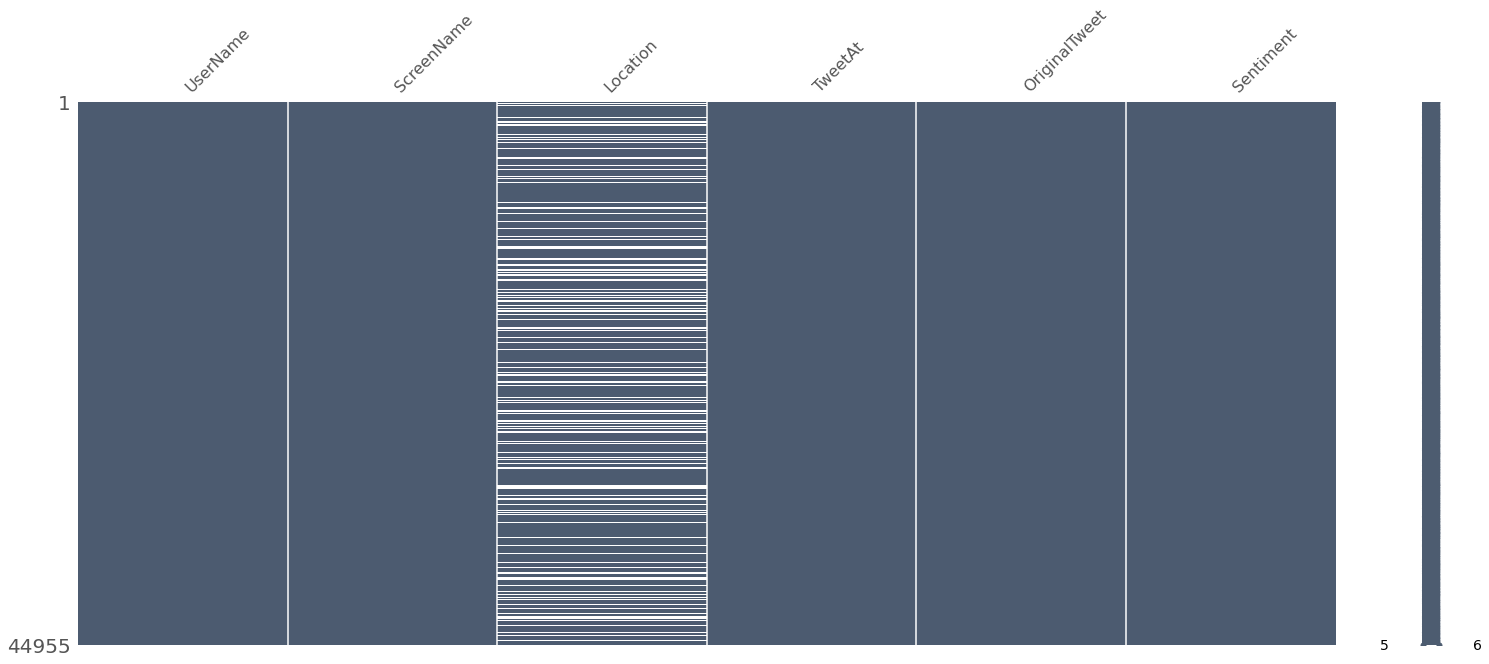

In [6]:
import missingno as msno
msno.matrix(df, color =(0.3, 0.36, 0.44))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [8]:
print(df.Sentiment.unique())
print(df.Sentiment.value_counts())

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


In [9]:
df['text'] = df.OriginalTweet
df['text'] = df['text'].astype(str)

train['text'] = train.OriginalTweet
train['text'] = train['text'].astype(str)

test['text'] = test.OriginalTweet
test['text'] = test['text'].astype(str)

def classes_def(x):
    if x == "Extremely Positive":
        return 'positive'
    if x == "Positive":
        return 'positive'
    if x == "Extremely Negative":
        return 'negative'
    if x == "Negative":
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['Sentiment'].apply(lambda x:classes_def(x))
train['sentiment'] = train['Sentiment'].apply(lambda x:classes_def(x))
test['sentiment'] = test['Sentiment'].apply(lambda x:classes_def(x))

In [10]:
target = df['sentiment']
df.sentiment.value_counts(normalize = True)

positive    0.435814
negative    0.378846
neutral     0.185341
Name: sentiment, dtype: float64

In [11]:
class_df = df.groupby('sentiment').count()['text'].reset_index().sort_values(by = 'text', ascending= False)
class_df.style.background_gradient(cmap = 'summer')

,sentiment,text
2,positive,19592
0,negative,17031
1,neutral,8332


In [12]:
percent_class = class_df.text
label = class_df.sentiment
colors = ['#17C37B','#F92969','#FACA0C']

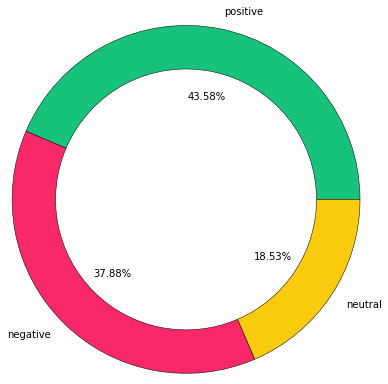

In [13]:
my_pie,_,_ = plt.pie(percent_class, radius = 2, labels = label, colors = colors, autopct = "%.2f%%")
plt.setp(my_pie, width = 0.5, edgecolor = 'black')
plt.show()

<BarContainer object of 3 artists>

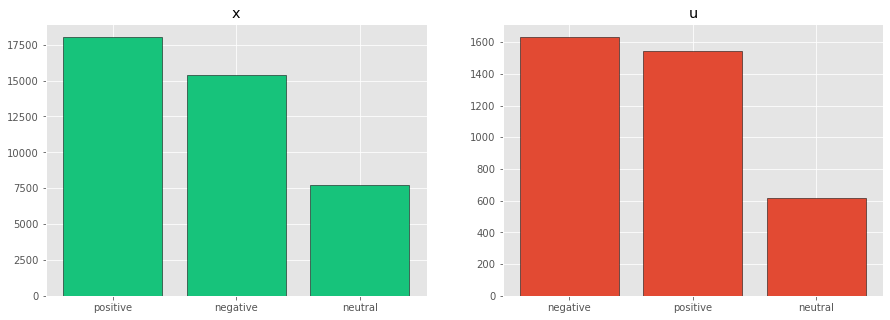

In [14]:
fig, (x, u) = plt.subplots(1,2, figsize = (15,5))
x.set_title('x')
u.set_title('u')
x.bar(x = train.sentiment.value_counts().index, height = train.sentiment.value_counts().values, color='#17C37B', edgecolor = 'black')
u.bar(x = test.sentiment.value_counts().index, height = test.sentiment.value_counts().values, edgecolor = 'black')

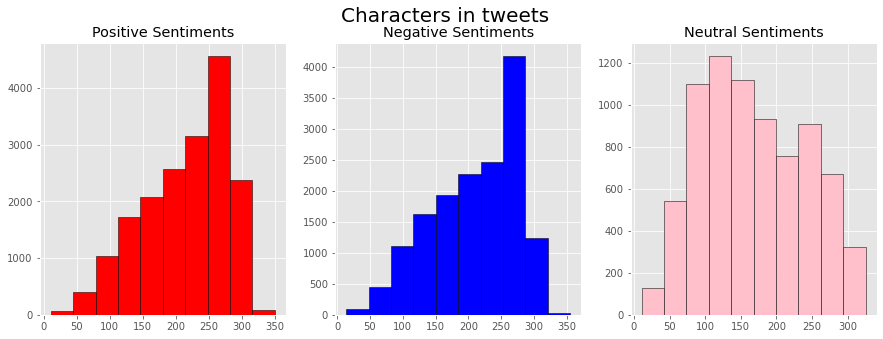

In [15]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,5))
tweet_len = train[train['sentiment'] == 'positive']['text'].str.len()
ax1.hist(tweet_len, color = 'red', edgecolor = 'black')
ax1.set_title('Positive Sentiments')

tweet_len = train[train['sentiment'] == 'negative']['text'].str.len()
ax2.hist(tweet_len, color = 'blue', edgecolor = 'black')
ax2.set_title('Negative Sentiments')

tweet_len = train[train['sentiment'] == 'neutral']['text'].str.len()
ax3.hist(tweet_len, color = 'pink', edgecolor = 'black')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets', size = 20)
plt.show()

Text(0.5, 1.0, 'Neutral Sentiments')

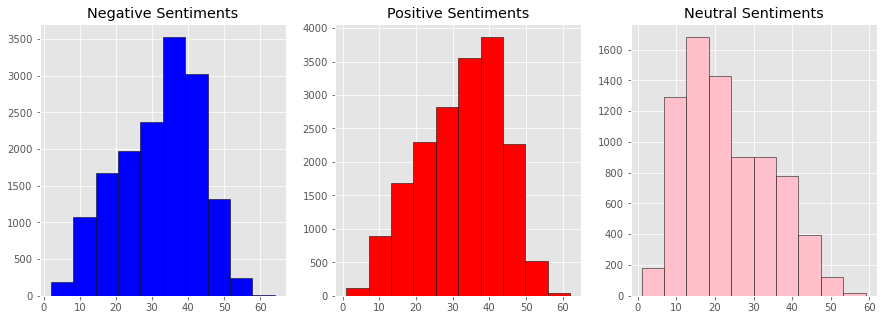

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

tweet_len =  train[train['sentiment'] == 'negative']['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color = 'blue', edgecolor = 'black')
ax1.set_title('Negative Sentiments')

tweet_len = train[train['sentiment'] == 'positive']['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color = 'red', edgecolor = 'black')
ax2.set_title('Positive Sentiments')

tweet_len = train[train['sentiment'] == 'neutral']['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len, color = 'pink', edgecolor = 'black')
ax3.set_title('Neutral Sentiments')

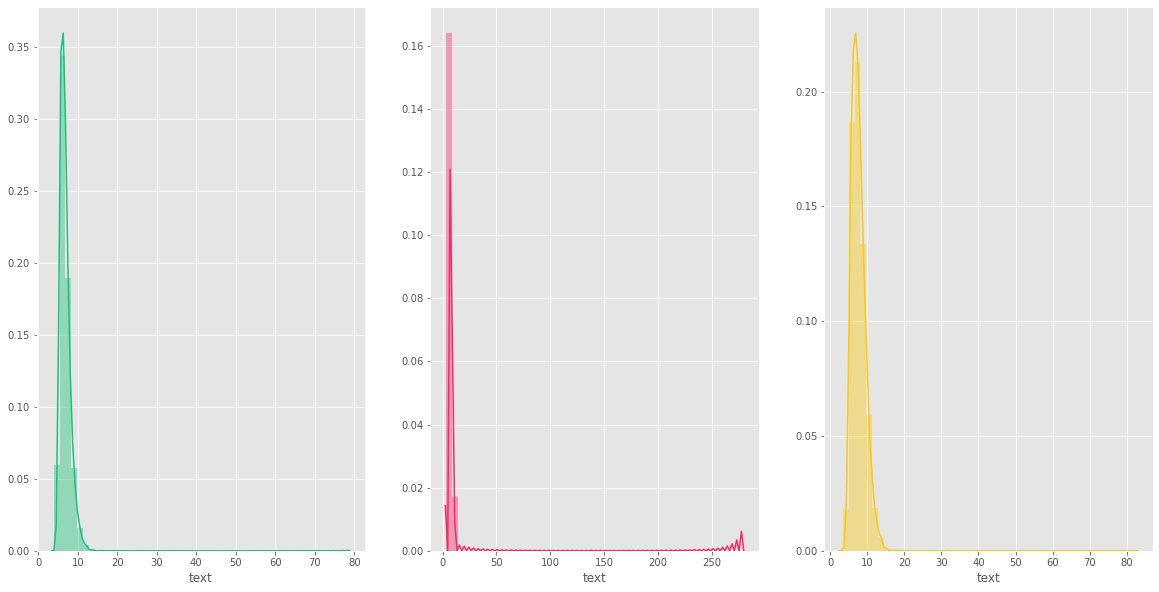

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,10))

tweet_len = train[train['sentiment'] == 'negative']['text'].str.len()/ train[train['sentiment'] == 'negative']['text'].str.split().map(lambda x: len(x))
sns.distplot(tweet_len,ax=ax1,color='#17C37B')

tweet_len = train[train['sentiment'] == 'positive']['text'].str.len()/ train[train['sentiment'] == 'positive']['text'].str.split().map(lambda x: len(x))
sns.distplot(tweet_len,ax=ax2,color='#F92969')

tweet_len = train[train['sentiment'] == 'neutral']['text'].str.len()/ train[train['sentiment'] == 'neutral']['text'].str.split().map(lambda x: len(x))
sns.distplot(tweet_len,ax=ax3,color='#FACA0C')

In [18]:
def create_corpous(target):
    corpus = []
    
    for x in train[train['sentiment'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [19]:
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stop=set(stopwords.words('english'))
from stop_words import get_stop_words
stop_words = get_stop_words('polish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lippd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
np.array(stop)

array({'up', 'by', 's', 'very', 'what', 'needn', 'shouldn', 'themselves', 'have', 'being', 'are', 'few', 'didn', 'been', "hasn't", 'at', 'from', 'not', 't', 'nor', 'doing', 'him', 'do', 'does', 'itself', 'me', 'am', "wouldn't", 'other', 'her', 'as', 'an', 'any', 'yourselves', "haven't", 'about', 'down', 're', 'below', "you'll", "won't", 'himself', 'while', 'd', 'he', 'is', 'our', 'should', "mightn't", 'most', 'hers', 'until', 'again', "should've", 'against', 'were', 'a', "isn't", 'my', 'now', 'your', 'own', "didn't", 'ours', "needn't", 'off', 'after', 'hadn', 'was', 'them', 'those', 'we', 'theirs', 'wasn', 'be', 'through', 'these', 'ain', 'which', 'to', 'on', 'don', "couldn't", "aren't", 'she', 'had', 'further', 'such', 'yourself', "shouldn't", "weren't", 'his', 'it', 'over', 'its', "shan't", 'or', 'mightn', 'how', 'under', 'y', 'couldn', 'i', 'doesn', 'then', "hadn't", 'can', 'yours', 'between', 'with', 'herself', "you're", 've', "she's", 'aren', 'into', 'that', 'ma', 'm', 'where', 'm

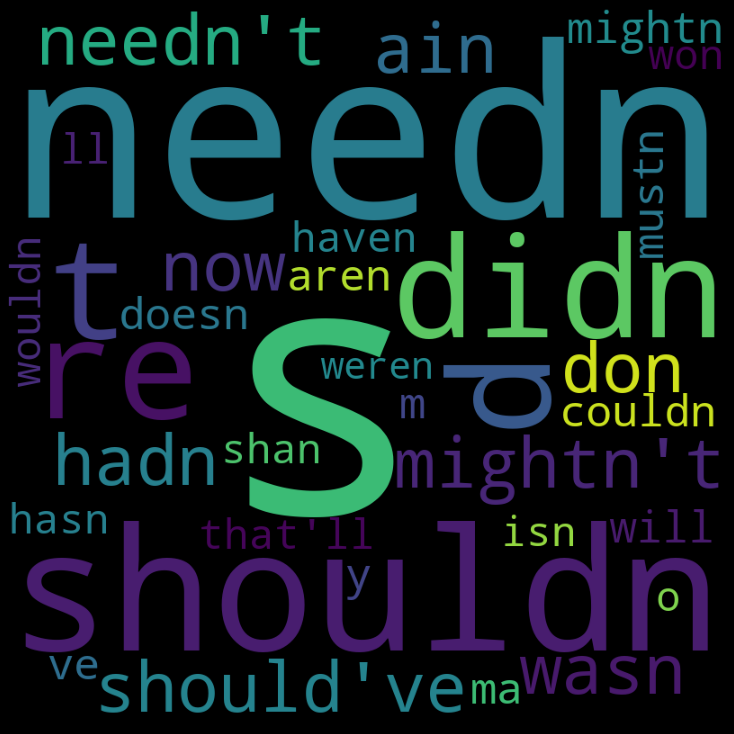

In [21]:
comment_words = ''
stopwords = set(STOPWORDS)
for val in stop:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,
                     background_color = 'black',
                     stopwords = stopwords,
                     min_font_size = 10).generate(comment_words)
plt.figure(figsize = (20, 10), facecolor = "black") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

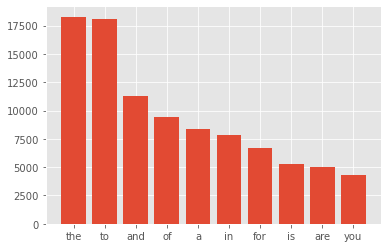

In [25]:
corpus = create_corpous('positive')

dic = defaultdict(int)
for i in corpus:
        if i in stop:
            dic[i] += 1
top = sorted(dic.items(), key = lambda x:x[1], reverse = True)[:10]
x, y = zip(*top)
plt.bar(x, y)
plt.show()

In [ ]:
stop_words

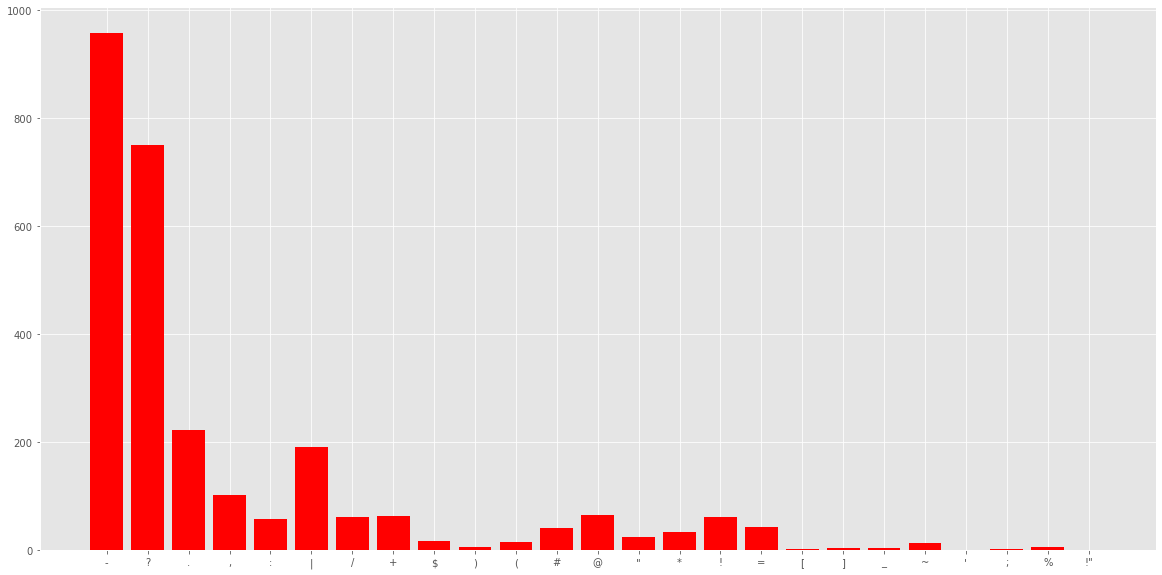

In [39]:
plt.figure(figsize = (20,10))
corpus = create_corpous('negative')
dic = defaultdict(int)
import string

s = string.punctuation


for i in (corpus):
    if i in s:
        dic[i] += 1
x,y=zip(*dic.items())

plt.bar(x, y, color = 'red')
plt.show()

In [62]:
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []

for i, j in most[:40]:
    if (i not in stop):
        x.append(i)
        y.append(j)        


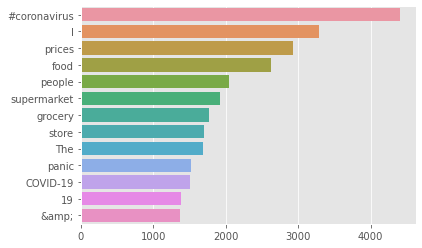

In [64]:
sns.barplot(x = y, y = x)

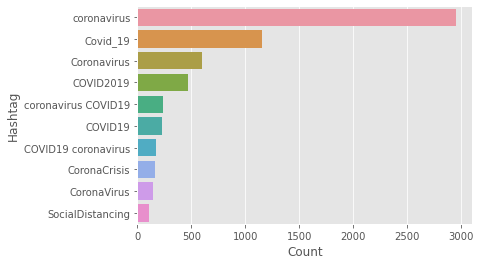

In [87]:
def find_hash(text):
    line = re.findall(r'(?<=#)\w+', text)
    return " ".join(line)

temp = df['hash'].value_counts()[:][1:11]
temp = temp.to_frame().reset_index().rename(columns = {'index':'Hashtag', 'hash':'Count'})
sns.barplot(x = "Count", y = 'Hashtag', data = temp)

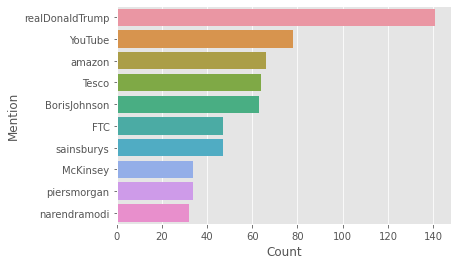

In [91]:
def find_mention(text):
    line = re.findall(r'(?<=@)\w+', text)
    return " ".join(line)

df['mention'] = df['text'].apply(lambda x: find_mention(x))
temp = df['mention'].value_counts()[:][1:11]
temp = temp.to_frame().reset_index().rename(columns = {'index':'Mention', 'mention':'Count'})
sns.barplot(x = "Count", y = 'Mention', data = temp)

In [93]:
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
df['text_new'] = df['text'].apply(lambda x: remove_urls(x))

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)
df['text'] = df['text_new'].apply(lambda x:remove_html(x))

In [96]:
def to_lower(text):
    lower = text.lower()
    return lower
df['text_new'] = df['text'].apply(lambda x:to_lower(x))

In [98]:
def remove_number(text):
    remove = re.sub(r'\d+', '', text)
    return remove
df['text'] = df['text_new'].apply(lambda x:remove_number(x))

In [122]:
def punct_remove(text):
    punct = re.sub(r'[^\w\s\d]', '', text)
    return punct
df['text_new'] = df['text'].apply(lambda x:punct_remove(x))              

In [154]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


In [152]:
for i in range(df['text_new']):
    print(i)

TypeError: 'Series' object cannot be interpreted as an integer

In [155]:
df['text']=df['text_new'].apply(lambda x:remove_stopwords(x))

In [159]:
def remove_mention(text):
    mention = re.sub(r'(?<=@)\w+', '', text)
    return mention

df['text_new'] = df['text'].apply(lambda x:remove_mention(x))

In [161]:
def remove_hash(text):
    hash1 = re.sub(r'(?<=#)\w+', '', text)
    return hash1

df['text_new'] = df['text'].apply(lambda x:remove_hash(x))